<a href="https://colab.research.google.com/github/juststudentinIT/Methods-of-Compression-and-Performance-Improvement-of-Deep-Neural-Networks/blob/main/RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

In [66]:
def identity_block(X, f, filters, stage, block):

  '''
  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shpae of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)
  
  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)
  
  # "Addition step" - skip-connection value merges with main path
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

In [67]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used
    """
    
    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'
    
    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters
    
    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions #### 
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step" 
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

In [68]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes
    
    """
    
    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((1, 1), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = layers.Dense(1000, activation='relu')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [69]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

In [70]:
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

In [71]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
history = model.fit(x_train, y_train, epochs = 5, batch_size = 32, validation_split= 0.1)

Epoch 1/5
1688/1688 [==============================] - 85s 47ms/step - loss: 0.6554 - accuracy: 0.7792 - val_loss: 0.4667 - val_accuracy: 0.8243
Epoch 2/5
1688/1688 [==============================] - 78s 46ms/step - loss: 0.4165 - accuracy: 0.8518 - val_loss: 0.4822 - val_accuracy: 0.8472
Epoch 3/5
1688/1688 [==============================] - 78s 46ms/step - loss: 0.4165 - accuracy: 0.8497 - val_loss: 0.4216 - val_accuracy: 0.8545
Epoch 4/5
1688/1688 [==============================] - 78s 46ms/step - loss: 0.3840 - accuracy: 0.8644 - val_loss: 0.3615 - val_accuracy: 0.8805
Epoch 5/5
1688/1688 [==============================] - 78s 46ms/step - loss: 0.3571 - accuracy: 0.8734 - val_loss: 0.4468 - val_accuracy: 0.8235


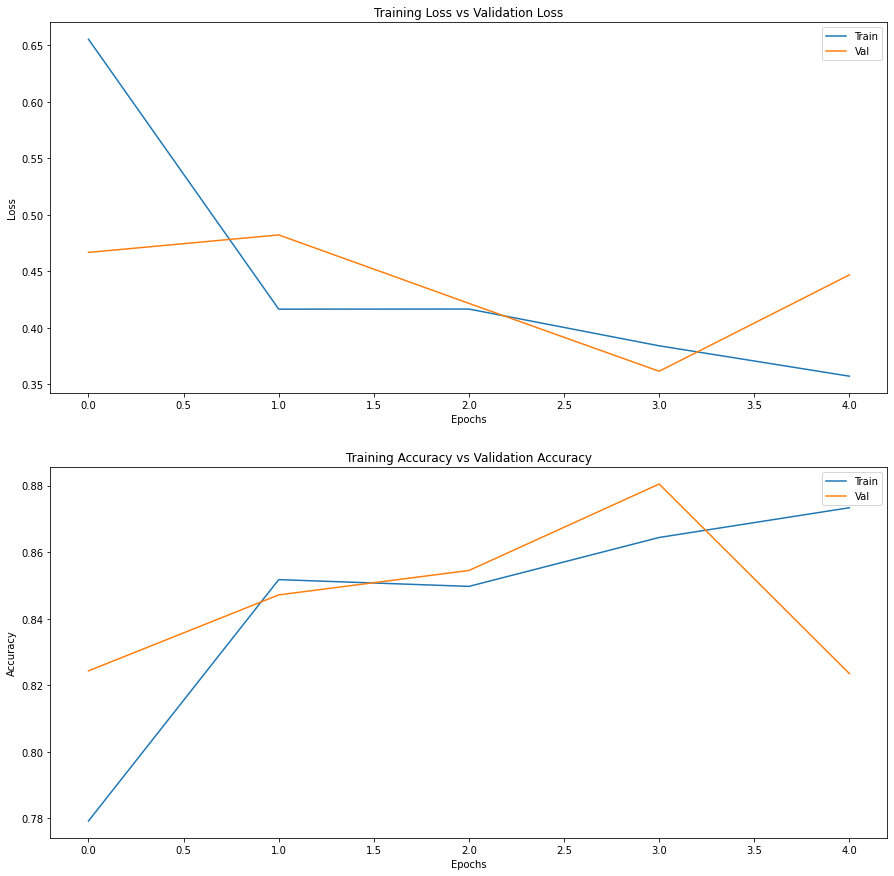

In [73]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [74]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 6s 18ms/step - loss: 0.4645 - accuracy: 0.8199


[0.4644811451435089, 0.8198999762535095]

##Post-training quantization

In [75]:
#Converts a TensorFlow model into TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_origin_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp23pe0y9j/assets


INFO:tensorflow:Assets written to: /tmp/tmp23pe0y9j/assets


In [76]:
#Model with quantizes weights 16 float
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #DEFAULT Default optimization strategy that quantizes model weights.
converter.target_spec.supported_types = [tf.float16]
tflite_model_quant_16 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpxm8s62qr/assets


INFO:tensorflow:Assets written to: /tmp/tmpxm8s62qr/assets


In [84]:
#Model with quantizes weights 8int
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant_8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpwqr566ej/assets


INFO:tensorflow:Assets written to: /tmp/tmpwqr566ej/assets


In [85]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_origin_model)
# Save the quantized model:
tflite_model_quant_16_file = tflite_models_dir/"model_quant16f.tflite"
tflite_model_quant_16_file.write_bytes(bytes(tflite_model_quant_16))
# Save the quantized model:
tflite_model_quant_8_file = tflite_models_dir/"model_quant8u.tflite"
tflite_model_quant_8_file.write_bytes(bytes(tflite_model_quant_8))

26200336

In [91]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global x_test
  #x_test = x_test[-500:]

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file)) #Interpreter interface for running TensorFlow Lite models.
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point


    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    #we want to avoid copying, so we  use the tensor() function to get a numpy buffer pointing
    #to the input buffer in the tflite interpreter.
    interpreter.set_tensor(input_details["index"], test_image) 
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()
    #print(i)

  return predictions

In [92]:
# Helper function to evaluate a TFLite model on all images
import time
def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test
  #x_test = x_test[-500:]
  #y_test = y_test[-500:]

  start_time = time.time()
  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)
  #print("here pred")
  accuracy = (np.sum(y_test == predictions) * 100) / len(x_test)
  spent_time = time.time() - start_time
  print('%s model accuracy is %.4f%% (Number of test samples=%d) , time = %f' % (
      model_type, accuracy, len(x_test), spent_time/len(x_test) ))

In [93]:
evaluate_model(tflite_model_file, model_type="Original")
evaluate_model(tflite_model_quant_16_file, model_type="Quantized 16float")
evaluate_model(tflite_model_quant_8_file, model_type="Quantized 8int")

Original model accuracy is 85.4000% (Number of test samples=500) , time = 0.014745
Quantized 16float model accuracy is 85.4000% (Number of test samples=500) , time = 0.013728
Quantized 8int model accuracy is 85.4000% (Number of test samples=500) , time = 0.251478


In [87]:
import os
print("Original model in Mb:", os.path.getsize(tflite_model_file) / float(2**20))
print("Quantized 16f model in Mb:", os.path.getsize(tflite_model_quant_16_file) / float(2**20))
print("Quantized 8u model in Mb:", os.path.getsize(tflite_model_quant_8_file) / float(2**20))

Original model in Mb: 97.46932601928711
Quantized 16f model in Mb: 48.776214599609375
Quantized 8u model in Mb: 24.986587524414062


##Aware quantization taining

In [94]:
 !pip install -q tensorflow
 !pip install -q tensorflow-model-optimization

In [95]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 quantize_layer_4 (QuantizeLaye  (None, 32, 32, 3)   3           ['input_9[0][0]']                
 r)                                                                                               
                                                                                                  
 quant_zero_padding2d_8 (Quanti  (None, 38, 38, 3)   1           ['quantize_layer_4[1][0]']       
 zeWrapperV2)                                                                                     
                                                                                           

In [96]:
q_aware_model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1688/1688 [==============================] - 1003s 576ms/step - loss: 0.5537 - accuracy: 0.8016 - val_loss: 1.0100 - val_accuracy: 0.6282
Epoch 2/5
1688/1688 [==============================] - 959s 568ms/step - loss: 0.9404 - accuracy: 0.6501 - val_loss: 0.6322 - val_accuracy: 0.7535
Epoch 3/5
1688/1688 [==============================] - 964s 571ms/step - loss: 0.5938 - accuracy: 0.7754 - val_loss: 0.4831 - val_accuracy: 0.8155
Epoch 4/5
1688/1688 [==============================] - 961s 570ms/step - loss: 0.4648 - accuracy: 0.8276 - val_loss: 0.3807 - val_accuracy: 0.8548
Epoch 5/5
1688/1688 [==============================] - 964s 571ms/step - loss: 0.4117 - accuracy: 0.8466 - val_loss: 0.3637 - val_accuracy: 0.8658


In [101]:
import tempfile
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

quant_converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
quant_converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = quant_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmmz0cl6k/assets


INFO:tensorflow:Assets written to: /tmp/tmpmmz0cl6k/assets


INFO:tensorflow:Assets written to: /tmp/tmp_4iqy7rn/assets


INFO:tensorflow:Assets written to: /tmp/tmp_4iqy7rn/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [102]:
print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

Float model in Mb: 97.46932601928711
Quantized model in Mb: 25.09473419189453


In [103]:
evaluate_model(float_file, model_type="Original")
evaluate_model(quant_file, model_type="Quantized 8int")

Original model accuracy is 85.4000% (Number of test samples=500) , time = 0.014008
Quantized 8int model accuracy is 87.0000% (Number of test samples=500) , time = 0.203778
